Importamos las herramientas/utils a utilizar

In [ ]:
import unicodedata
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import unicodedata
from nltk.corpus import stopwords
import pandas as pd
from nltk.stem import PorterStemmer  # Importar la clase PorterStemmer
import random
import numpy as np
import pandas as pd
from collections import Counter # Exploración
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración
import unicodedata # Preprocesado
import re # Preprocesado
import random
import numpy as np
import pandas as pd
from collections import Counter # Exploración
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración
import unicodedata # Preprocesado
import re # Preprocesado
from sklearn.model_selection import train_test_split # Modelado
from sklearn.pipeline import Pipeline # Modelado
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Modelado
from sklearn.feature_selection import chi2 # Reporte
from sklearn.linear_model import LogisticRegression # Reporte
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve # Reporte
import matplotlib.pyplot as plt
import gzip
import json
import pandas as pd
import urllib.request
import random
import numpy as np
import pandas as pd
from collections import Counter # Exploración
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración
import unicodedata # Preprocesado
import re # Preprocesado
from sklearn.model_selection import train_test_split # Modelado
from sklearn.pipeline import Pipeline # Modelado
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Modelado
from sklearn.feature_selection import chi2 # Reporte
from sklearn.linear_model import LogisticRegression # Reporte
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve # Reporte
import matplotlib.pyplot as plt

Repetimos la bajada de datos

In [1]:
! wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Toys_and_Games_5.json.gz

--2024-03-23 18:35:04--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Toys_and_Games_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42057555 (40M) [application/x-gzip]
Saving to: ‘reviews_Toys_and_Games_5.json.gz.1’

reviews_Toys_and_Ga 100%[===================>]  40.11M  10.9MB/s    in 5.3s    

2024-03-23 18:35:09 (7.54 MB/s) - ‘reviews_Toys_and_Games_5.json.gz.1’ saved [42057555/42057555]



In [2]:

url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Toys_and_Games_5.json.gz'
urllib.request.urlretrieve(url, 'reviews_Toys_and_Games_5.json.gz')

('reviews_Toys_and_Games_5.json.gz',
 <http.client.HTTPMessage at 0x7a9fb017d390>)

Y los convertimos en una lista de diccionarios.

In [ ]:
# Lista para almacenar los datos
data = []

# Abre el archivo JSON comprimido y descomprímelo
with gzip.open('reviews_Toys_and_Games_5.json.gz', 'rt', encoding='utf-8') as f:
    # Lee cada línea del archivo
    for line in f:
        # Carga el contenido de la línea en un diccionario
        item = json.loads(line)
        # Agrega el diccionario a la lista de datos
        data.append(item)

# Ahora puedes trabajar con los datos, que estarán en forma de una lista de diccionarios. Los pasamos a un dataframe
df = pd.DataFrame(data)

Veamos la estructura de los datos

In [6]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1VXOAVRGKGEAK,0439893577,Angie,"[0, 0]",I like the item pricing. My granddaughter want...,5.0,Magnetic board,1390953600,"01 29, 2014"
1,A8R62G708TSCM,0439893577,Candace,"[1, 1]",Love the magnet easel... great for moving to d...,4.0,it works pretty good for moving to different a...,1395964800,"03 28, 2014"
2,A21KH420DK0ICA,0439893577,capemaychristy,"[1, 1]",Both sides are magnetic. A real plus when you...,5.0,love this!,1359331200,"01 28, 2013"
3,AR29QK6HPFYZ4,0439893577,dcrm,"[0, 0]",Bought one a few years ago for my daughter and...,5.0,Daughters love it,1391817600,"02 8, 2014"
4,ACCH8EOML6FN5,0439893577,DoyZ,"[1, 1]",I have a stainless steel refrigerator therefor...,4.0,Great to have so he can play with his alphabet...,1399248000,"05 5, 2014"


In [7]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

Procedemos a definir la función de normalización y limpieza, que pasará las palabras a minusculas, creará tokens por palabras, eliminará los caracteres especiales, quitará las stopwords, eliminará palabras que son muy comunes pero no aportan (item, pricing) y aplicará un stemming para poder utilizar terminos normalizados en los modelos predictivos.

In [9]:

# Crear una instancia de PorterStemmer
stemmer = PorterStemmer()

# Definir la función de normalización
def normalizacion(review):
    # Separar la revisión en palabras
    review = review.split()
    # Convertir todas las palabras a minúsculas
    review = [word.lower() for word in review]
    # Quitar espacios en blanco al inicio y al final de la revisión
    review = [word.strip() for word in review]
    # Normalizar caracteres especiales
    review = [unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in review]
    # Obtener lista de palabras vacías en inglés
    sw_list = set(stopwords.words('english'))
    # Eliminar palabras vacías de la revisión
    review = [word for word in review if word not in sw_list]
    # Eliminar letras huecas (necesario para que el ejercicio de n-gram tenga sentido)
    review = [word for word in review if word not in [',', '.', "'"]]
    # Eliminar las palabras 'pricing' y 'item' del texto
    review = [word for word in review if word not in ['pricing', 'item']]
    # Aplicar stemming a cada palabra
    review = [stemmer.stem(word) for word in review]
    # Unir las palabras en una cadena de texto
    review = ' '.join(review)
    return review

# Aplicar la función de normalización a la columna 'reviewText'
df['reviewText_norm'] = df['reviewText'].apply(normalizacion)

# Imprimir el DataFrame con la columna normalizada
print(df['reviewText_norm'].head())



0    like pricing. granddaught want mark want letters.
1    love magnet easel... great move differ areas.....
2    side magnetic. real plu entertain one child. f...
3    bought one year ago daughter love it, still us...
4    stainless steel refriger therefor much space s...
Name: reviewText_norm, dtype: object


También aplicamos un "preprocesado" a la variable a determinar. Asi que el "sentimiento" es la puntuación del review-.

In [10]:
new_df=df[['overall','reviewText_norm']]
new_df=new_df.dropna(subset=['reviewText_norm'])
new_df = new_df.rename(columns={'overall': 'sentiment', 'reviewText_norm': 'review'})
new_df['sentiment_label'] = new_df['sentiment'].apply(lambda x: 1 if x > 3 else 0)
new_df.head()

,sentiment,review,sentiment_label
0,5.0,like pricing. granddaught want mark want letters.,1
1,4.0,love magnet easel... great move differ areas.....,1
2,5.0,side magnetic. real plu entertain one child. f...,1
3,5.0,"bought one year ago daughter love it, still us...",1
4,4.0,stainless steel refriger therefor much space s...,1


Como fase previa del modelo también vamos a practicar una vectorización de las palabras en la muestra.  Para ello, aplicaremos un método de TFVectorizer. La separación entre "train y test" nos servirá además para comparar modelos más tarde.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df['review'],
    new_df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

Aplicamos la vectorización

In [15]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=3, strip_accents='ascii')

A continuación, transformamos en Train y Test para poder aplicar modelos.

In [18]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

Vamos a ver las palabras que parecen tener un impacto más significativo sobre el sentimiento declarado como "puntuación". Para hacerlo construimos el gráfico de Chi cuadrado sobre el conjunto de palabras.

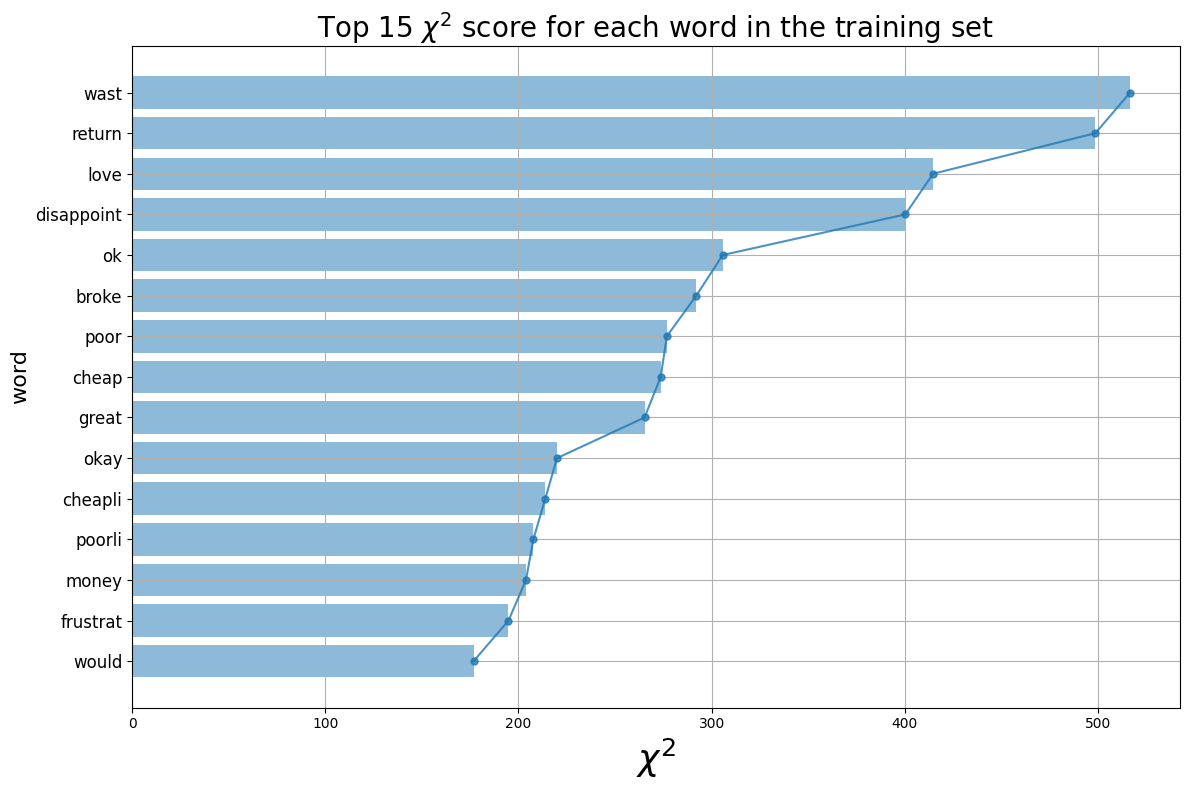

In [35]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names_out(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

Parece que tiene sentido. waste, return, love, dissapoint....son todas ellas palabras que parecen muy relacionadas con el sentimiento que causa un juguete o juego. Podemos concluir que el preprocesado ha concluido satisfactoriamente